In [1]:
import numpy as np
from PIL import Image
import os
import pandas as pd

I will work with the leather dataset

In [2]:
base_dir = './archive/leather'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
gt_dir = os.path.join(base_dir,'ground_truth')

In [3]:
# Initialize lists to store data for DataFrame
data_train = []
data_test = []
data_gt = []
# Handle "good" folder
# Gather images from "train" folder
train_good_dir = os.path.join(train_dir, "good")
if os.path.exists(train_good_dir):
    train_good_images = os.listdir(train_good_dir)
    for img_name in train_good_images:
        img_path = os.path.join(train_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in train
        category = "good"
        mask = 0
        data_train.append([img_path, mask_path, category, mask])
# Gather images from "test/good" folder
test_good_dir = os.path.join(test_dir, "good")
if os.path.exists(test_good_dir):
    test_good_images = os.listdir(test_good_dir)
    for img_name in test_good_images:
        img_path = os.path.join(test_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in test
        category = "good"
        mask = 0
        data_test.append([img_path, mask_path, category, mask])

gt_categories = ['color','cut','fold','glue','poke']
for category in gt_categories:
    test_category_dir = os.path.join(test_dir, category)
    gt_category_dir = os.path.join(gt_dir, category)
    if os.path.exists(test_category_dir) and os.path.exists(gt_category_dir):
        test_images = os.listdir(test_category_dir)
        for img_name in test_images:
            img_path = os.path.join(test_category_dir, img_name)
            mask_name = img_name.split('.')[0] + "_mask.png"
            mask_path = os.path.join(gt_category_dir, mask_name)
            mask_category = category
            mask = 1
            data_gt.append([img_path, mask_path, mask_category, mask])


# Create a DataFrame
df_train = pd.DataFrame(data_train, columns=["image_path", "mask_path", "categories", "mask"])

In [4]:
df_train.head(-5)

image_path mask_path categories  mask
0    ./archive/leather\train\good\000.png                 good     0
1    ./archive/leather\train\good\001.png                 good     0
2    ./archive/leather\train\good\002.png                 good     0
3    ./archive/leather\train\good\003.png                 good     0
4    ./archive/leather\train\good\004.png                 good     0
..                                    ...       ...        ...   ...
235  ./archive/leather\train\good\235.png                 good     0
236  ./archive/leather\train\good\236.png                 good     0
237  ./archive/leather\train\good\237.png                 good     0
238  ./archive/leather\train\good\238.png                 good     0
239  ./archive/leather\train\good\239.png                 good     0

[240 rows x 4 columns]

In [7]:
df_train.shape

(245, 4)

In [8]:
df_train['categories'].value_counts()

categories
good    245
Name: count, dtype: int64

Perform data augmentation

We need to augment the data to feed the autoencoder to have more samples that are crucial to show more possibilities to the autoencoder so it could detect correctly the anomalies

In [9]:
from torchvision import transforms
import albumentations as A #albumentations is a libary to augment easily image data
from albumentations.pytorch import ToTensorV2
import torch

In [10]:
# Define the augmentation transformations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    ToTensorV2(),
])

In [11]:
# Create directories to save augmented images
output_image_dir = './working/aug/image/'
os.makedirs(output_image_dir, exist_ok=True)

In [12]:
augmented_data = []
for index,row in df_train.iterrows():
    image_path = row['image_path']
    category = row['categories']

    # Load the image
    image = np.array(Image.open(image_path))
    
    # Apply augmentations to the image
    augmented = augmentations(image=image)
    augmented_image = augmented['image']

    # Convert PyTorch tensor to NumPy array
    augmented_image = augmented_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC
    
    # Ensure pixel values are in the range [0, 1] (undo normalization)
    augmented_image = augmented_image.astype(np.float32) / 255.0

    # Save augmented images and masks
    image_filename = f'{category}_{index}_aug.png'
    augmented_image_path = os.path.join(output_image_dir, image_filename)
    
    Image.fromarray((augmented_image * 255).astype(np.uint8)).save(augmented_image_path)  # Convert back to uint8
    
    # Append augmented data to the list
    augmented_data.append([augmented_image_path, black_image_path, category, 0])

In [13]:
# Create a DataFrame for augmented data
augmented_df = pd.DataFrame(augmented_data, columns=["image_path", "mask_path", "categories", "mask"])

# Concatenate the original DataFrame 'df' with the augmented DataFrame
concatenated_df = pd.concat([df_train, augmented_df], ignore_index=True)

# Display the concatenated DataFrame
concatenated_df.tail(50)

image_path  \
440  ./working/aug/image/good_195_aug.png   
441  ./working/aug/image/good_196_aug.png   
442  ./working/aug/image/good_197_aug.png   
443  ./working/aug/image/good_198_aug.png   
444  ./working/aug/image/good_199_aug.png   
445  ./working/aug/image/good_200_aug.png   
446  ./working/aug/image/good_201_aug.png   
447  ./working/aug/image/good_202_aug.png   
448  ./working/aug/image/good_203_aug.png   
449  ./working/aug/image/good_204_aug.png   
450  ./working/aug/image/good_205_aug.png   
451  ./working/aug/image/good_206_aug.png   
452  ./working/aug/image/good_207_aug.png   
453  ./working/aug/image/good_208_aug.png   
454  ./working/aug/image/good_209_aug.png   
455  ./working/aug/image/good_210_aug.png   
456  ./working/aug/image/good_211_aug.png   
457  ./working/aug/image/good_212_aug.png   
458  ./working/aug/image/good_213_aug.png   
459  ./working/aug/image/good_214_aug.png   
460  ./working/aug/image/good_215_aug.png   
461  ./working/aug/image/good_216_aug.png   
462  ./working/aug/image/good_217_aug.png   
463  ./working/aug/image/good_218_aug.png   
464  ./working/aug/image/good_219_aug.png   
465  ./working/aug/image/good_220_aug.png   
466  ./working/aug/image/good_221_aug.png   
467  ./working/aug/image/good_222_aug.png   
468  ./working/aug/image/good_223_aug.png   
469  ./working/aug/image/good_224_aug.png   
470  ./working/aug/image/good_225_aug.png   
471  ./working/aug/image/good_226_aug.png   
472  ./working/aug/image/good_227_aug.png   
473  ./working/aug/image/good_228_aug.png   
474  ./working/aug/image/good_229_aug.png   
475  ./working/aug/image/good_230_aug.png   
476  ./working/aug/image/good_231_aug.png   
477  ./working/aug/image/good_232_aug.png   
478  ./working/aug/image/good_233_aug.png   
479  ./working/aug/image/good_234_aug.png   
480  ./working/aug/image/good_235_aug.png   
481  ./working/aug/image/good_236_aug.png   
482  ./working/aug/image/good_237_aug.png   
483  ./working/aug/image/good_238_aug.png   
484  ./working/aug/image/good_239_aug.png   
485  ./working/aug/image/good_240_aug.png   
486  ./working/aug/image/good_241_aug.png   
487  ./working/aug/image/good_242_aug.png   
488  ./working/aug/image/good_243_aug.png   
489  ./working/aug/image/good_244_aug.png   

                                   mask_path categories  mask  
440  ./archive/leather/train/black_image.png       good     0  
441  ./archive/leather/train/black_image.png       good     0  
442  ./archive/leather/train/black_image.png       good     0  
443  ./archive/leather/train/black_image.png       good     0  
444  ./archive/leather/train/black_image.png       good     0  
445  ./archive/leather/train/black_image.png       good     0  
446  ./archive/leather/train/black_image.png       good     0  
447  ./archive/leather/train/black_image.png       good     0  
448  ./archive/leather/train/black_image.png       good     0  
449  ./archive/leather/train/black_image.png       good     0  
450  ./archive/leather/train/black_image.png       good     0  
451  ./archive/leather/train/black_image.png       good     0  
452  ./archive/leather/train/black_image.png       good     0  
453  ./archive/leather/train/black_image.png       good     0  
454  ./archive/leather/train/black_image.png       good     0  
455  ./archive/leather/train/black_image.png       good     0  
456  ./archive/leather/train/black_image.png       good     0  
457  ./archive/leather/train/black_image.png       good     0  
458  ./archive/leather/train/black_image.png       good     0  
459  ./archive/leather/train/black_image.png       good     0  
460  ./archive/leather/train/black_image.png       good     0  
461  ./archive/leather/train/black_image.png       good     0  
462  ./archive/leather/train/black_image.png       good     0  
463  ./archive/leather/train/black_image.png       good     0  
464  ./archive/leather/train/black_image.png       good     0  
465  ./archive/leather/train/black_image.png       good     0  
466  ./

In [14]:
concatenated_df['mask'].value_counts()

mask
0    490
Name: count, dtype: int64

In [15]:
concatenated_df.isnull().sum()

image_path    0
mask_path     0
categories    0
mask          0
dtype: int64

Now we create the neural network using a combination of convolution, max pooling and up sampling

In [16]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, GaussianNoise
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
# Define the encoder
def create_autoencoder(input_shape):
    input_img = tf.keras.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # 128x128
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # 64x64
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2))(x)  # 32x32

    # Decoder
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # 64x64
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # 128x128
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # 256x256
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output: 256x256x3

    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder


autoencoder = create_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')

In [17]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train, test = train_test_split(concatenated_df, test_size = 0.3, random_state=42)
test, val = train_test_split(test,test_size = 0.5, random_state=42)

In [20]:
train.shape

(343, 4)

In [21]:
test.shape

(73, 4)

In [22]:
val.shape

(74, 4)

With the data splitted it is time to load the images

In [23]:
import cv2

In [24]:
def img_to_num(path:str):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img/255.0
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 3))
    return img

In [25]:
train_image_paths = train.loc[:,"image_path"].tolist()
train_dataset = [img_to_num(path) for path in train_image_paths]

In [26]:
val_image_paths = val.loc[:,"image_path"].tolist()
val_dataset = [img_to_num(path) for path in val_image_paths]

In [27]:
train_dataset = np.array(train_dataset)
val_dataset = np.array(val_dataset)

In [31]:
epochs = 20
history = autoencoder.fit(x=train_dataset, y=train_dataset, epochs=epochs,batch_size=32, validation_data=[val_dataset, val_dataset])

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - loss: 0.0297 - val_loss: 0.0051
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0051 - val_loss: 0.0040
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0040 - val_loss: 0.0033
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0034 - val_loss: 0.0026
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 0.0014 - val_lo

In [32]:
import matplotlib.pyplot as plt

In [34]:
test_image_path = test.loc[:,"image_path"].tolist()
test_dataset = [img_to_num(path) for path in test_image_path]

Let's plot the real images and the predicted ones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


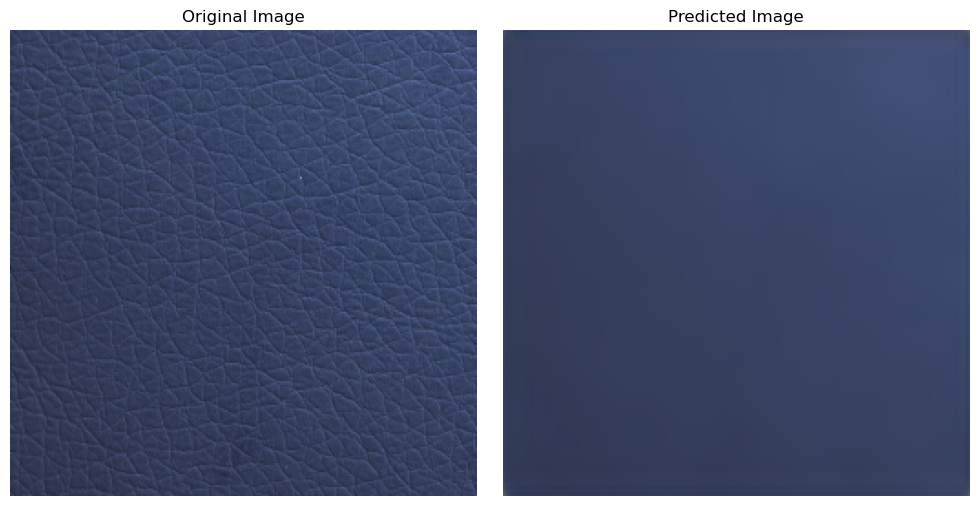

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


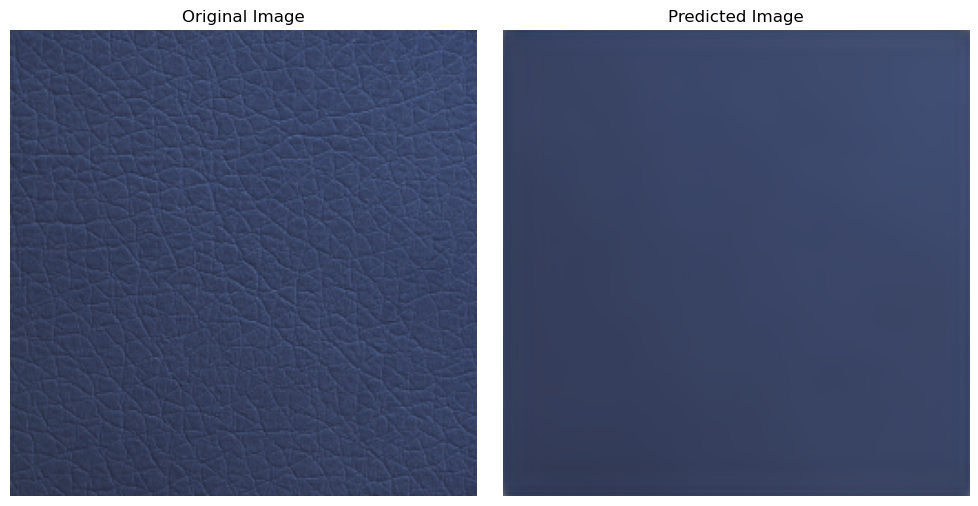

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


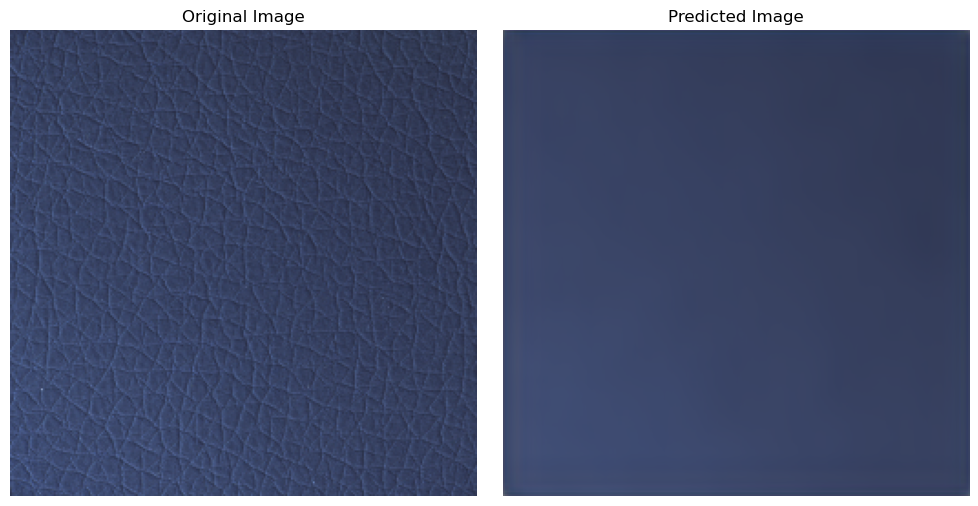

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


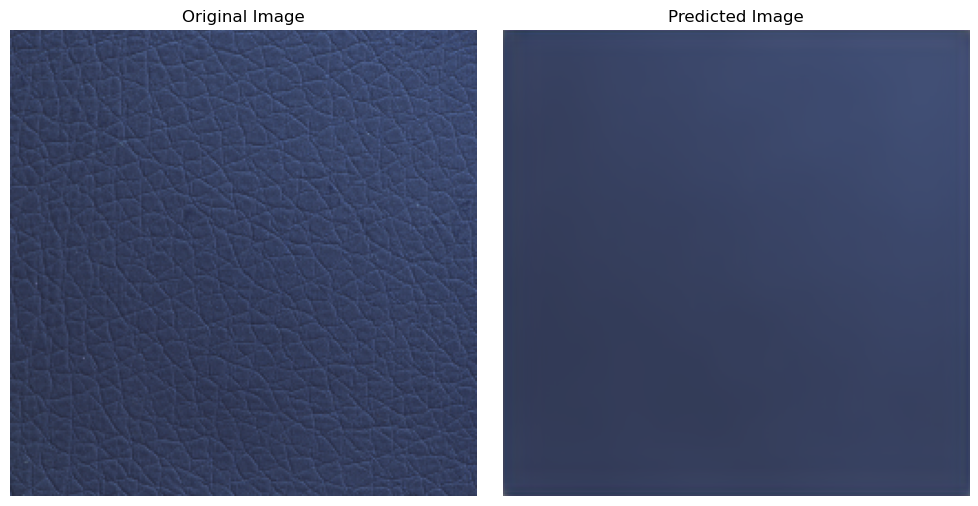

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


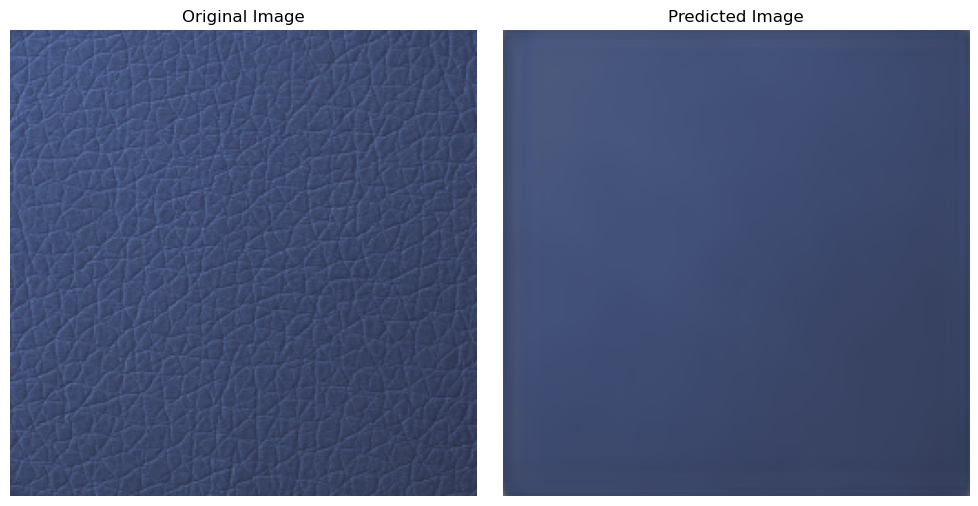

In [42]:
for i in range(5):
    real_image = test_dataset[i]
    real_image_predict = np.expand_dims(real_image, axis=0)
    predicted_image = autoencoder.predict(real_image_predict)
    predicted_image = np.squeeze(predicted_image, axis=0)
   
    plt.figure(figsize=(10, 5))
    
    # Display the original image
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(real_image)
    plt.axis('off')
    
    # Display the predicted_image
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Image')
    plt.imshow(predicted_image) 
    plt.axis('off')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

The NN does not retain the texture of the original image but this may not be a problem. Let's calculate the reconstruction errors for the anomalies

In [43]:
def calculate_reconstruction_error(model, data):
    reconstructions = model.predict(data)
    # Using MSE (adjust as needed if you used a different loss)
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=(1, 2, 3))  # Average across image dimensions
    return reconstruction_errors

In [44]:
gt_df = pd.DataFrame(data_gt, columns=["image_path", "mask_path", "categories", "mask"])
gt_df.head(5)

image_path  \
0  ./archive/leather\test\color\000.png   
1  ./archive/leather\test\color\001.png   
2  ./archive/leather\test\color\002.png   
3  ./archive/leather\test\color\003.png   
4  ./archive/leather\test\color\004.png   

                                           mask_path categories  mask  
0  ./archive/leather\ground_truth\color\000_mask.png      color     1  
1  ./archive/leather\ground_truth\color\001_mask.png      color     1  
2  ./archive/leather\ground_truth\color\002_mask.png      color     1  
3  ./archive/leather\ground_truth\color\003_mask.png      color     1  
4  ./archive/leather\ground_truth\color\004_mask.png      color     1

In [46]:
gt_image_path = gt_df.loc[:,"image_path"].tolist()
gt_dataset = [img_to_num(path) for path in gt_image_path]
gt_dataset = np.array(gt_dataset)

In [51]:
reconstruction_errors = calculate_reconstruction_error(autoencoder, gt_dataset)

reconstruction_errors.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step


(92,)

Let's find the threshold to consider a piece of leather an anomaly. 
It is important that the amount of anomalies detected is a great percentage while the amount of false anomalies is low

In [52]:
def find_threshold(errors, percentile=95):
    threshold = np.percentile(errors, percentile)
    return threshold

In [65]:
training_errors = calculate_reconstruction_error(autoencoder, train_dataset)
threshold = find_threshold(training_errors, percentile=90)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step


In [66]:
print(f"Anomaly threshold: {threshold}")

Anomaly threshold: 0.02831394374370575


In [73]:
def detect_anomalies(errors, threshold):
    anomalies = errors > threshold
    return anomalies

anomalies = detect_anomalies(reconstruction_errors, threshold)

print(f"Number of anomalies detected: {np.sum(anomalies)}")

Number of anomalies detected: 81


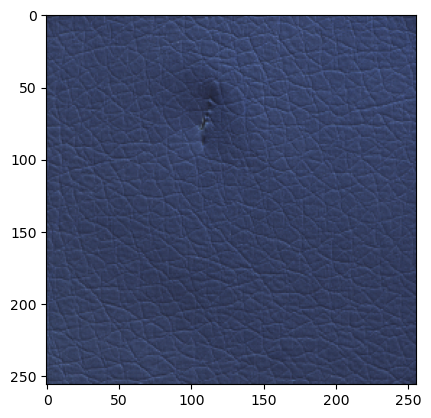

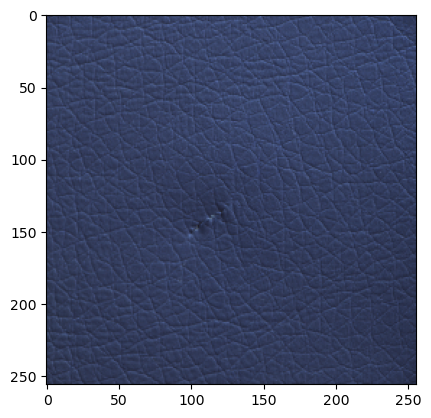

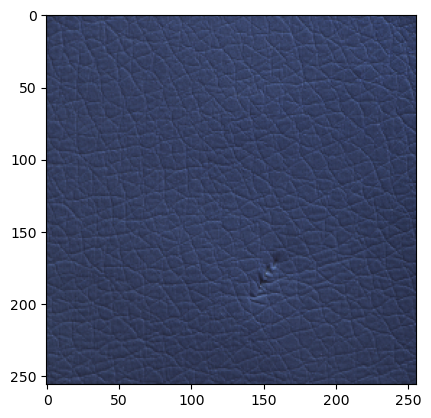

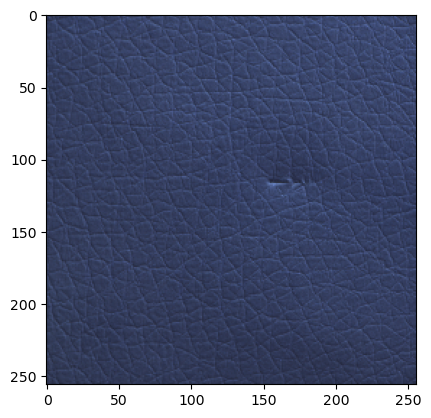

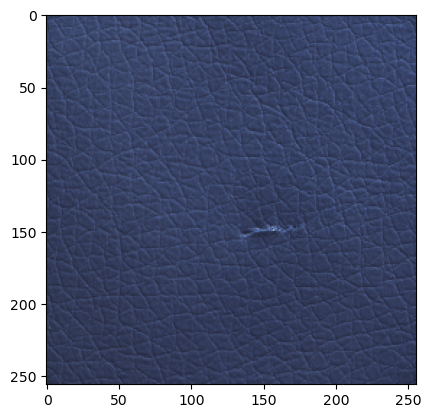

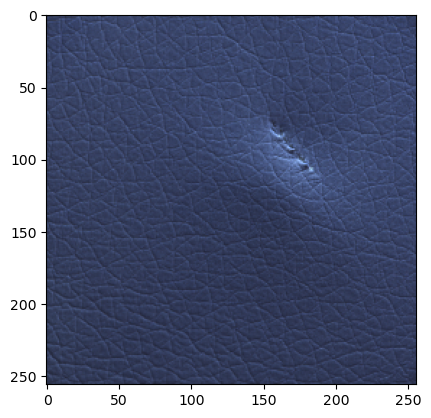

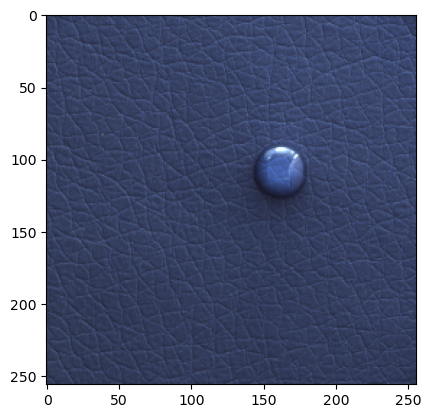

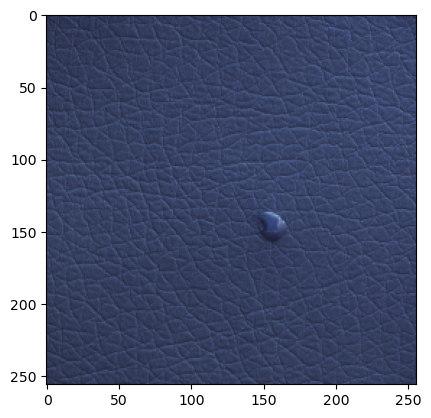

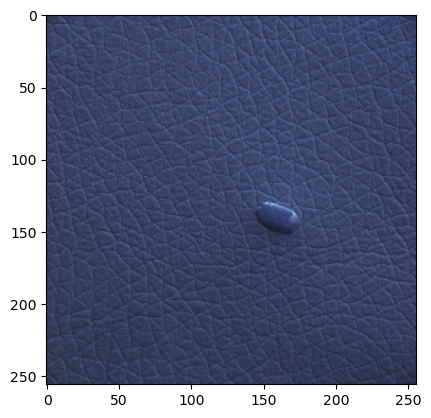

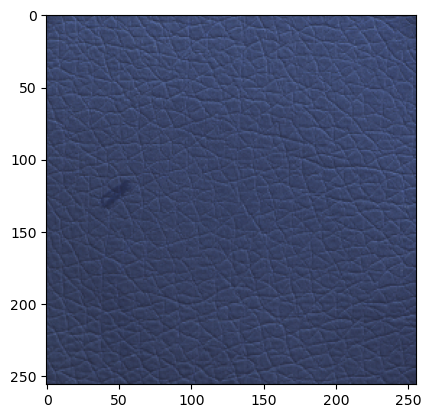

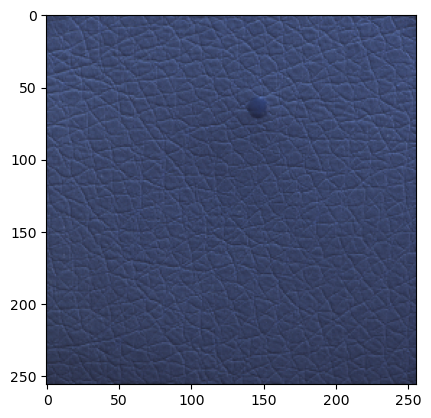

In [74]:
for i,anomaly in enumerate(anomalies):#plot the missed anomalies
    if anomaly:
        continue
    plt.imshow(gt_dataset[i])
    plt.show()

In [68]:
print(f"Accuracy: {round(np.sum(anomalies)/len(gt_dataset)*100,2)}%")

Accuracy: 88.04%


In [69]:
test_dataset = np.array(test_dataset)
reconstruction_errors_test = calculate_reconstruction_error(autoencoder, test_dataset)

reconstruction_errors_test.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step


(73,)

In [72]:
anomalies = detect_anomalies(reconstruction_errors_test, threshold)

print(f"Number of anomalies detected: {np.sum(anomalies)}")

Number of anomalies detected: 6


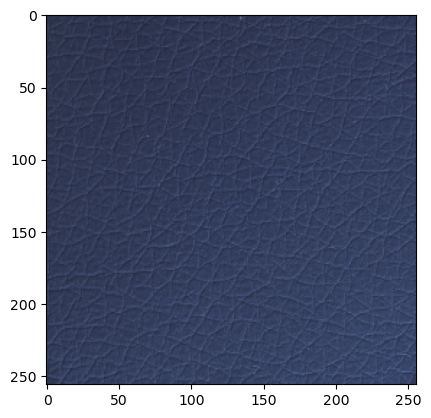

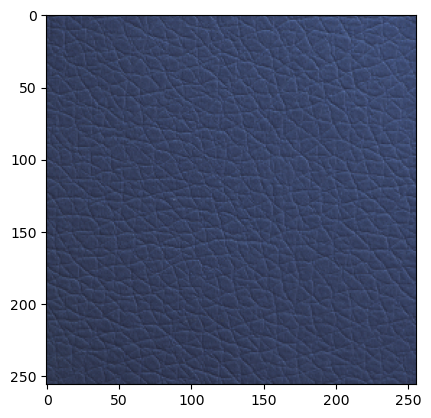

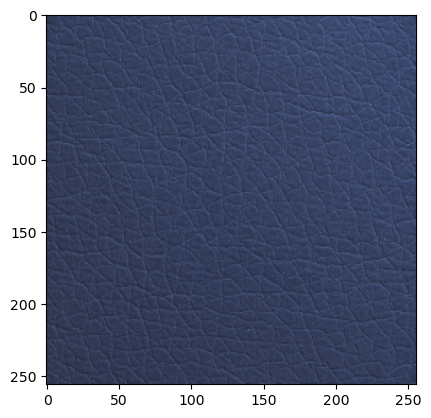

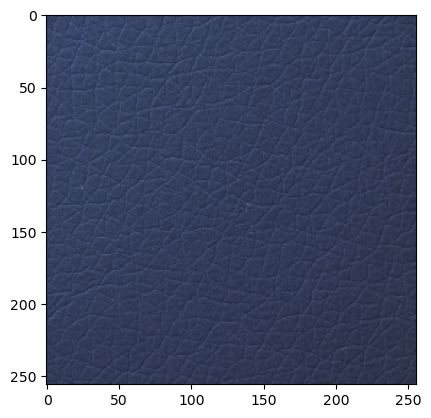

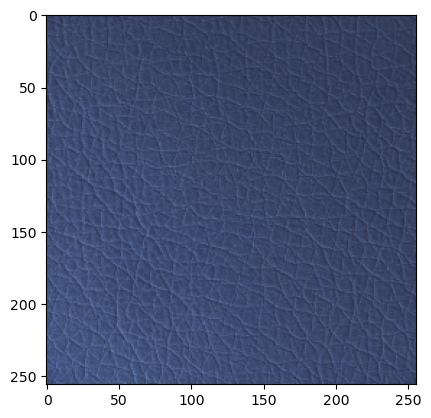

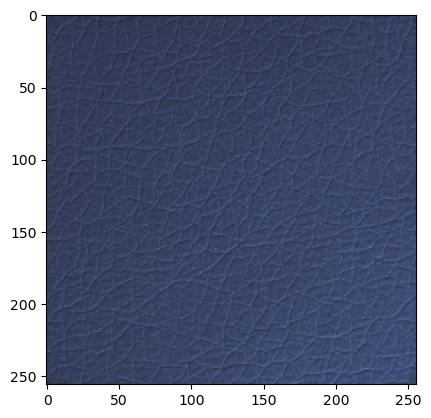

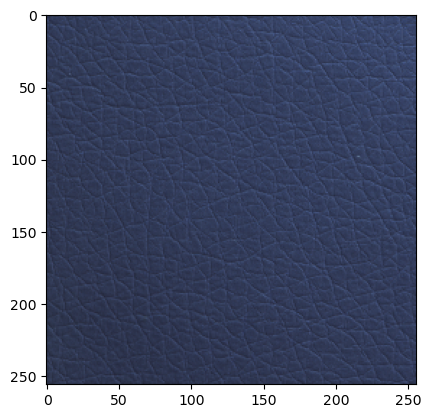

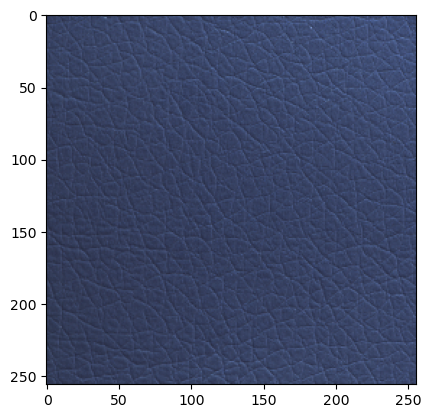

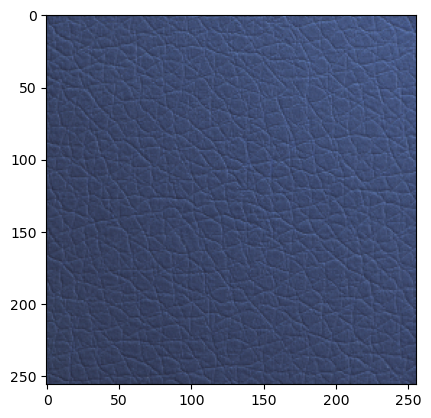

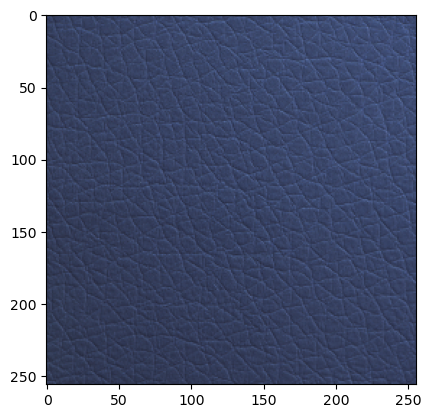

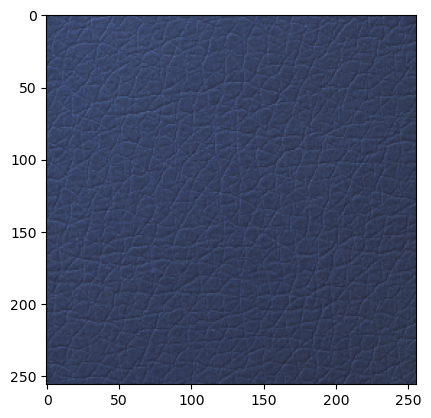

In [75]:
for i,anomaly in enumerate(anomalies): #plot the anomalies that were falsely detected
    if anomaly:
        continue
    plt.imshow(test_dataset[i])
    plt.show()

In conclusion the reconstruction model is capable of detect 88% of the anomalies while assigning anomalous only 8% of the not anomalous leather 